# Car Price prediction
Предсказание стоимости автомобиля с помощью различных моделей ML и DL, используя различные типы данных.

## Part 2 : ML и DL модели

* Построим "наивную" модель, предсказывающую цену по модели и году выпуска (с ней будем сравнивать другие модели)
* Сделаем модель на основе градиентного бустинга с помощью CatBoost
* Сделаем модель на основе нейронных сетей и сравним результаты
* Сделаем multi-input нейронную сеть для анализа табличных данных и текста одновременно
* Добавим в multi-input сеть обработку изображений
* Осуществим ансамблирование градиентного бустинга и нейронной сети (усреднение их предсказаний)
* Получим итоговые предсказания с помощью усреднения всех предсказаний моделей (исходные/округленные)

# Библиотеки

In [2]:
import numpy as np
import pandas as pd
import os
pd.set_option('display.max_columns', None)

# For NLP
import nltk
from nltk.probability import FreqDist
from nltk import word_tokenize
from nltk.corpus import stopwords
#from pymystem3 import Mystem
from string import punctuation
import re

# For ML
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_classif

# Keras
import tensorflow as tf

# GPU memory
config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8))
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

# Charts
import PIL
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 12, 6

# Константы

In [3]:
# Фиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Функции

In [4]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

def preproc_data_default(df_input):

    df_output = df_input.copy()

    # убираем не нужные для модели признаки
    df_output.drop(['description', 'sell_id'], axis=1, inplace=True)

    # Логарифмирование
    for col in numerical_features:
        df_output[col] = np.log(df_output[col] + 1)
    # df_output['price'] = np.log(df_output['price'] + 1)

    # Нормализация данных
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:, 0]

    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes

    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(
        df_output, columns=categorical_features, dummy_na=False)

    return df_output

# Данные

Используем получившийся датасет из "Part 1 : EDA и формирование датасета"

In [5]:
SF_DIR = '../input/sf-dst-car-price-prediction-part2/'
DATA_DIR = '../input/data-car-price-part-2/'
data = pd.read_csv(DATA_DIR + 'data.csv')
sample_submission = pd.read_csv(SF_DIR + 'sample_submission.csv')

In [6]:
data.head(2)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,numberOfDoors,productionDate,sell_id,vehicleTransmission,Владельцы,ПТС,Привод,sample,price,model,xDrive,sDrive,CDI,AMG,BlueTEC,Long,длинный,4MATIC,BlueEfficiency,TRONIC,компактный,HYBRID,torg,leather,ABS,airbags,central_locking,on_board_computer,light_and_rain_sensors,mileage_prod_date,mileage_owns,owns_year
0,универсал,MERCEDES,чёрный,300 задний w124 бензин черный mercedes универс...,3.0,220,бензин,350000,1984,W124,5,1991,1099427284,автоматическая,3,Оригинал,задний,0,0.0,300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,11666,116666,10
1,купе,BMW,белый,640d полный 6er дизель белый bmw купе любимый...,3.0,313,дизель,15000,2011,6ER,2,2013,1096405886,автоматическая,1,Оригинал,полный,0,0.0,640d,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1875,15000,8


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8350 entries, 0 to 8349
Data columns (total 42 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   bodyType                8350 non-null   object 
 1   brand                   8350 non-null   object 
 2   color                   8350 non-null   object 
 3   description             8350 non-null   object 
 4   engineDisplacement      8350 non-null   float64
 5   enginePower             8350 non-null   int64  
 6   fuelType                8350 non-null   object 
 7   mileage                 8350 non-null   int64  
 8   modelDate               8350 non-null   int64  
 9   model_info              8350 non-null   object 
 10  numberOfDoors           8350 non-null   int64  
 11  productionDate          8350 non-null   int64  
 12  sell_id                 8350 non-null   int64  
 13  vehicleTransmission     8350 non-null   object 
 14  Владельцы               8350 non-null   

In [8]:
# Категориальные признаки
categorical_features = [
    'bodyType',
    'brand',
    'color',
    'fuelType',
    'model_info',
    'numberOfDoors',
    'vehicleTransmission',
    'Владельцы',
    'ПТС',
    'Привод',
    'model'
]

# Числовые признаки
numerical_features = [
    'engineDisplacement',
    'mileage',
    'modelDate',
    'mileage_prod_date',
    'mileage_owns',
    'owns_year',
    'productionDate',
    'enginePower'
]

# Model 1: Создадим "наивную" модель 
Модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.


In [9]:
train_data = data.query('sample == 1').drop(['sample'], axis=1)

data_train, data_test = train_test_split(train_data, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [10]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 20.19%


# Model 2: CatBoostRegressor
Модель на основе градиентного бустинга

In [11]:
def preproc_data(df_input):
    
    df_output = df_input.copy()
    
    # убираем не нужные для модели признаки
    df_output.drop(['description'], axis = 1, inplace=True)

    # Логарифмирование
    for col in numerical_features:
        df_output[col] = np.log(df_output[col] + 1)
    df_output['price'] = np.log(df_output['price'] + 1)
        
    return df_output

In [12]:
df_preproc = preproc_data(data)

train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

## Fit

In [13]:
model = CatBoostRegressor(iterations = 2000,learning_rate = 0.1,random_seed = RANDOM_SEED,eval_metric='MAPE') #logging_level='Silent'

model.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          cat_features=categorical_features,
          verbose_eval=500,
          use_best_model=True,
          plot=False
          )

0:	learn: 0.0395180	test: 0.0383026	best: 0.0383026 (0)	total: 71.8ms	remaining: 2m 23s
500:	learn: 0.0067104	test: 0.0086107	best: 0.0086107 (500)	total: 8.61s	remaining: 25.8s
1000:	learn: 0.0053596	test: 0.0084834	best: 0.0084783 (981)	total: 18s	remaining: 17.9s
1500:	learn: 0.0044975	test: 0.0085057	best: 0.0084769 (1133)	total: 27.1s	remaining: 9s
1999:	learn: 0.0038664	test: 0.0085482	best: 0.0084769 (1133)	total: 36s	remaining: 0us

bestTest = 0.008476850088
bestIteration = 1133

Shrink model to first 1134 iterations.


In [14]:
test_predict_catboost = model.predict(X_test)
test_predict_catboost = np.exp(test_predict_catboost)

print(f"TEST mape: {(mape(np.exp(y_test), test_predict_catboost))*100:0.2f}%")

TEST mape: 12.00%


Точность CatBoostRegressor выше, чем у наивной модели. Сохраним результаты.

## Predict

In [15]:
sub_predict = model.predict(X_sub)
sub_predict = np.exp(sub_predict)

sample_submission['price'] = sub_predict
sample_submission.to_csv('catboost.csv', index=False)

# округлим
sample_submission['price'] = (sample_submission['price'] // 1000) * 1000
sample_submission.to_csv('catboost_round.csv', index=False)

# Model 3: Tabular NN
Модель на основе нейронных сетей

In [16]:
df_preproc = preproc_data_default(data)

train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [17]:
K.clear_session()

model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.25))
model.add(L.Dense(1, activation="linear"))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               223232    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 354,817
Trainable params: 354,817
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE', optimizer=optimizer, metrics=['MAPE'])

In [20]:
checkpoint = ModelCheckpoint(
    'working/best_model_tabular_nn.hdf5', monitor=['val_MAPE'], verbose=1, mode='min')
earlystop = EarlyStopping(
    monitor='val_MAPE', patience=50, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

## Fit

In [21]:
%%time
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500,  # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=1,
                    )

Epoch 1/500
12/12 [==============================] - 2s 63ms/step - loss: 99.9973 - MAPE: 99.9973 - val_loss: 99.9459 - val_MAPE: 99.9459

Epoch 00001: saving model to working/best_model_tabular_nn.hdf5
Epoch 2/500
12/12 [==============================] - 0s 10ms/step - loss: 99.8434 - MAPE: 99.8434 - val_loss: 99.1399 - val_MAPE: 99.1399

Epoch 00002: saving model to working/best_model_tabular_nn.hdf5
Epoch 3/500
12/12 [==============================] - 0s 10ms/step - loss: 98.4934 - MAPE: 98.4934 - val_loss: 95.2779 - val_MAPE: 95.2779

Epoch 00003: saving model to working/best_model_tabular_nn.hdf5
Epoch 4/500
12/12 [==============================] - 0s 10ms/step - loss: 93.1786 - MAPE: 93.1786 - val_loss: 83.9002 - val_MAPE: 83.9002

Epoch 00004: saving model to working/best_model_tabular_nn.hdf5
Epoch 5/500
12/12 [==============================] - 0s 10ms/step - loss: 78.8550 - MAPE: 78.8550 - val_loss: 59.9673 - val_MAPE: 59.9673

Epoch 00005: saving model to working/best_model_t

12/12 [==============================] - 0s 10ms/step - loss: 25.8004 - MAPE: 25.8004 - val_loss: 24.7216 - val_MAPE: 24.7216

Epoch 00041: saving model to working/best_model_tabular_nn.hdf5
Epoch 42/500
12/12 [==============================] - 0s 10ms/step - loss: 25.8246 - MAPE: 25.8246 - val_loss: 24.3715 - val_MAPE: 24.3715

Epoch 00042: saving model to working/best_model_tabular_nn.hdf5
Epoch 43/500
12/12 [==============================] - 0s 11ms/step - loss: 25.2583 - MAPE: 25.2583 - val_loss: 24.0978 - val_MAPE: 24.0978

Epoch 00043: saving model to working/best_model_tabular_nn.hdf5
Epoch 44/500
12/12 [==============================] - 0s 16ms/step - loss: 24.6710 - MAPE: 24.6710 - val_loss: 23.8470 - val_MAPE: 23.8470

Epoch 00044: saving model to working/best_model_tabular_nn.hdf5
Epoch 45/500
12/12 [==============================] - 0s 14ms/step - loss: 24.5597 - MAPE: 24.5597 - val_loss: 23.4387 - val_MAPE: 23.4387

Epoch 00045: saving model to working/best_model_tabular_n

12/12 [==============================] - 0s 9ms/step - loss: 17.7516 - MAPE: 17.7516 - val_loss: 17.2405 - val_MAPE: 17.2405

Epoch 00081: saving model to working/best_model_tabular_nn.hdf5
Epoch 82/500
12/12 [==============================] - 0s 10ms/step - loss: 17.5519 - MAPE: 17.5519 - val_loss: 17.2053 - val_MAPE: 17.2053

Epoch 00082: saving model to working/best_model_tabular_nn.hdf5
Epoch 83/500
12/12 [==============================] - 0s 10ms/step - loss: 17.3179 - MAPE: 17.3179 - val_loss: 16.9638 - val_MAPE: 16.9638

Epoch 00083: saving model to working/best_model_tabular_nn.hdf5
Epoch 84/500
12/12 [==============================] - 0s 10ms/step - loss: 17.2997 - MAPE: 17.2997 - val_loss: 16.7189 - val_MAPE: 16.7189

Epoch 00084: saving model to working/best_model_tabular_nn.hdf5
Epoch 85/500
12/12 [==============================] - 0s 10ms/step - loss: 16.8512 - MAPE: 16.8512 - val_loss: 16.7584 - val_MAPE: 16.7584

Epoch 00085: saving model to working/best_model_tabular_nn

12/12 [==============================] - 0s 15ms/step - loss: 14.4104 - MAPE: 14.4104 - val_loss: 14.2188 - val_MAPE: 14.2188

Epoch 00121: saving model to working/best_model_tabular_nn.hdf5
Epoch 122/500
12/12 [==============================] - 0s 10ms/step - loss: 14.4625 - MAPE: 14.4625 - val_loss: 14.4047 - val_MAPE: 14.4047

Epoch 00122: saving model to working/best_model_tabular_nn.hdf5
Epoch 123/500
12/12 [==============================] - 0s 10ms/step - loss: 14.5479 - MAPE: 14.5479 - val_loss: 14.2331 - val_MAPE: 14.2331

Epoch 00123: saving model to working/best_model_tabular_nn.hdf5
Epoch 124/500
12/12 [==============================] - 0s 10ms/step - loss: 14.4920 - MAPE: 14.4920 - val_loss: 14.2275 - val_MAPE: 14.2275

Epoch 00124: saving model to working/best_model_tabular_nn.hdf5
Epoch 125/500
12/12 [==============================] - 0s 10ms/step - loss: 14.5452 - MAPE: 14.5452 - val_loss: 14.0982 - val_MAPE: 14.0982

Epoch 00125: saving model to working/best_model_tabul

12/12 [==============================] - 0s 11ms/step - loss: 13.3493 - MAPE: 13.3493 - val_loss: 13.5079 - val_MAPE: 13.5079

Epoch 00161: saving model to working/best_model_tabular_nn.hdf5
Epoch 162/500
12/12 [==============================] - 0s 10ms/step - loss: 13.2196 - MAPE: 13.2196 - val_loss: 13.2522 - val_MAPE: 13.2522

Epoch 00162: saving model to working/best_model_tabular_nn.hdf5
Epoch 163/500
12/12 [==============================] - 0s 10ms/step - loss: 13.2789 - MAPE: 13.2789 - val_loss: 13.2749 - val_MAPE: 13.2749

Epoch 00163: saving model to working/best_model_tabular_nn.hdf5
Epoch 164/500
12/12 [==============================] - 0s 10ms/step - loss: 13.5152 - MAPE: 13.5152 - val_loss: 13.2637 - val_MAPE: 13.2637

Epoch 00164: saving model to working/best_model_tabular_nn.hdf5
Epoch 165/500
12/12 [==============================] - 0s 10ms/step - loss: 13.3474 - MAPE: 13.3474 - val_loss: 13.2878 - val_MAPE: 13.2878

Epoch 00165: saving model to working/best_model_tabul

12/12 [==============================] - 0s 10ms/step - loss: 12.6296 - MAPE: 12.6296 - val_loss: 12.9849 - val_MAPE: 12.9849

Epoch 00201: saving model to working/best_model_tabular_nn.hdf5
Epoch 202/500
12/12 [==============================] - 0s 10ms/step - loss: 12.7564 - MAPE: 12.7564 - val_loss: 13.0207 - val_MAPE: 13.0207

Epoch 00202: saving model to working/best_model_tabular_nn.hdf5
Epoch 203/500
12/12 [==============================] - 0s 10ms/step - loss: 12.8120 - MAPE: 12.8120 - val_loss: 12.9480 - val_MAPE: 12.9480

Epoch 00203: saving model to working/best_model_tabular_nn.hdf5
Epoch 204/500
12/12 [==============================] - 0s 10ms/step - loss: 12.8884 - MAPE: 12.8884 - val_loss: 13.0040 - val_MAPE: 13.0040

Epoch 00204: saving model to working/best_model_tabular_nn.hdf5
Epoch 205/500
12/12 [==============================] - 0s 10ms/step - loss: 12.7574 - MAPE: 12.7574 - val_loss: 13.0112 - val_MAPE: 13.0112

Epoch 00205: saving model to working/best_model_tabul

12/12 [==============================] - 0s 10ms/step - loss: 12.2939 - MAPE: 12.2939 - val_loss: 12.8284 - val_MAPE: 12.8284

Epoch 00241: saving model to working/best_model_tabular_nn.hdf5
Epoch 242/500
12/12 [==============================] - 0s 10ms/step - loss: 12.4063 - MAPE: 12.4063 - val_loss: 12.8673 - val_MAPE: 12.8673

Epoch 00242: saving model to working/best_model_tabular_nn.hdf5
Epoch 243/500
12/12 [==============================] - 0s 10ms/step - loss: 12.4774 - MAPE: 12.4774 - val_loss: 13.0422 - val_MAPE: 13.0422

Epoch 00243: saving model to working/best_model_tabular_nn.hdf5
Epoch 244/500
12/12 [==============================] - 0s 10ms/step - loss: 12.1896 - MAPE: 12.1896 - val_loss: 12.8809 - val_MAPE: 12.8809

Epoch 00244: saving model to working/best_model_tabular_nn.hdf5
Epoch 245/500
12/12 [==============================] - 0s 10ms/step - loss: 12.4308 - MAPE: 12.4308 - val_loss: 12.8581 - val_MAPE: 12.8581

Epoch 00245: saving model to working/best_model_tabul

12/12 [==============================] - 0s 10ms/step - loss: 12.0122 - MAPE: 12.0122 - val_loss: 12.7644 - val_MAPE: 12.7644

Epoch 00281: saving model to working/best_model_tabular_nn.hdf5
Epoch 282/500
12/12 [==============================] - 0s 10ms/step - loss: 12.0981 - MAPE: 12.0981 - val_loss: 12.7316 - val_MAPE: 12.7316

Epoch 00282: saving model to working/best_model_tabular_nn.hdf5
Epoch 283/500
12/12 [==============================] - 0s 9ms/step - loss: 11.9344 - MAPE: 11.9344 - val_loss: 12.7981 - val_MAPE: 12.7981

Epoch 00283: saving model to working/best_model_tabular_nn.hdf5
Epoch 284/500
12/12 [==============================] - 0s 10ms/step - loss: 11.9546 - MAPE: 11.9546 - val_loss: 12.7665 - val_MAPE: 12.7665

Epoch 00284: saving model to working/best_model_tabular_nn.hdf5
Epoch 285/500
12/12 [==============================] - 0s 10ms/step - loss: 11.9782 - MAPE: 11.9782 - val_loss: 12.7749 - val_MAPE: 12.7749

Epoch 00285: saving model to working/best_model_tabula

12/12 [==============================] - 0s 10ms/step - loss: 11.7819 - MAPE: 11.7819 - val_loss: 12.6074 - val_MAPE: 12.6074

Epoch 00321: saving model to working/best_model_tabular_nn.hdf5
Epoch 322/500
12/12 [==============================] - 0s 10ms/step - loss: 11.8208 - MAPE: 11.8208 - val_loss: 12.7035 - val_MAPE: 12.7035

Epoch 00322: saving model to working/best_model_tabular_nn.hdf5
Epoch 323/500
12/12 [==============================] - 0s 10ms/step - loss: 11.5307 - MAPE: 11.5307 - val_loss: 12.7360 - val_MAPE: 12.7360

Epoch 00323: saving model to working/best_model_tabular_nn.hdf5
Epoch 324/500
12/12 [==============================] - 0s 10ms/step - loss: 11.6988 - MAPE: 11.6988 - val_loss: 12.7077 - val_MAPE: 12.7077

Epoch 00324: saving model to working/best_model_tabular_nn.hdf5
Epoch 325/500
12/12 [==============================] - 0s 10ms/step - loss: 11.9747 - MAPE: 11.9747 - val_loss: 12.7256 - val_MAPE: 12.7256

Epoch 00325: saving model to working/best_model_tabul

12/12 [==============================] - 0s 10ms/step - loss: 11.2727 - MAPE: 11.2727 - val_loss: 12.7674 - val_MAPE: 12.7674

Epoch 00361: saving model to working/best_model_tabular_nn.hdf5
Epoch 362/500
12/12 [==============================] - 0s 10ms/step - loss: 11.7787 - MAPE: 11.7787 - val_loss: 12.7163 - val_MAPE: 12.7163

Epoch 00362: saving model to working/best_model_tabular_nn.hdf5
Epoch 363/500
12/12 [==============================] - 0s 10ms/step - loss: 11.7736 - MAPE: 11.7736 - val_loss: 12.7022 - val_MAPE: 12.7022

Epoch 00363: saving model to working/best_model_tabular_nn.hdf5
Epoch 364/500
12/12 [==============================] - 0s 10ms/step - loss: 11.6081 - MAPE: 11.6081 - val_loss: 12.6500 - val_MAPE: 12.6500

Epoch 00364: saving model to working/best_model_tabular_nn.hdf5
Epoch 365/500
12/12 [==============================] - 0s 10ms/step - loss: 11.6187 - MAPE: 11.6187 - val_loss: 12.7579 - val_MAPE: 12.7579

Epoch 00365: saving model to working/best_model_tabul

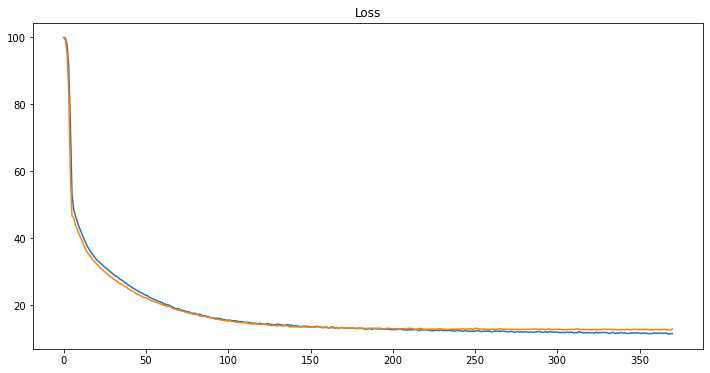

In [22]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [23]:
model.load_weights('working/best_model_tabular_nn.hdf5')
model.save('working/nn_3.hdf5')

In [24]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 12.87%


Точность текущей модели выше, чем у наивной модели. Но ниже,чем у CatBoostRegressor. Сохраним результаты для усреднения.

## Predict

In [26]:
sub_predict = model.predict(X_sub)

sample_submission['price'] = sub_predict[:, 0]
sample_submission.to_csv('model_3.csv', index=False)

# округлим
sample_submission['price'] = (sample_submission['price'] // 1000) * 1000
sample_submission.to_csv('model_3_round.csv', index=False)

# Model 4: NN + NLP + Multiple Inputs
Multi-input нейронная сеть для анализа табличных данных и текста одновременно

In [27]:
df_preproc = preproc_data_default(data)

train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [28]:
data.description

0       300 задний w124 бензин черный mercedes универс...
1        640d полный 6er дизель белый bmw купе любимый...
2        325xi полный 3er бензин пурпурный bmw купе пе...
3        318i задний 3er бензин белый bmw седан отличн...
4        520d полный 5er дизель черный bmw седан немка...
                              ...                        
8345     320i задний 3er бензин серый bmw седан любимы...
8346     520d задний 5er дизель черный bmw седан офици...
8347     318i задний 3er бензин белый bmw седан торг м...
8348     long полный a8 бензин черный audi седан отлич...
8349     pullman задний s klasse бензин черный mercede...
Name: description, Length: 8350, dtype: object

In [29]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [30]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

## Tokenizer

In [31]:
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [32]:
%%time
text_train_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape,
      text_test_sequences.shape, text_sub_sequences.shape)

(5677, 256) (1002, 256) (1671, 256)
CPU times: user 1.17 s, sys: 2.78 ms, total: 1.17 s
Wall time: 1.17 s


In [33]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

 50i полный x6 бензин черный bmw внедорожник идеальный состояние самый полный комплектация крашеный деталь полностью заводской окрас обслуживание официальный дилер bmw 
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0

## RNN NLP

In [34]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

## MLP

In [35]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.25))

## Multiple Inputs NN

In [36]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [37]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     5820928     seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 256)     525312      embedding[0][0]                  
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 256, 256)     0           lstm[0][0]                       
______________________________________________________________________________________________

## Fit

In [38]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE', optimizer=optimizer, metrics=['MAPE'])

In [39]:
checkpoint = ModelCheckpoint(
    r'/working/best_model_nn_mlp_nlp.hdf5', monitor=['val_MAPE'], verbose=1, mode='min')
earlystop = EarlyStopping(
    monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [40]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500,  # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                    )

Epoch 1/500
12/12 [==============================] - 8s 319ms/step - loss: 99.9959 - MAPE: 99.9959 - val_loss: 99.8482 - val_MAPE: 99.8482

Epoch 00001: saving model to /working/best_model_nn_mlp_nlp.hdf5
Epoch 2/500
12/12 [==============================] - 3s 267ms/step - loss: 99.2470 - MAPE: 99.2470 - val_loss: 93.2442 - val_MAPE: 93.2442

Epoch 00002: saving model to /working/best_model_nn_mlp_nlp.hdf5
Epoch 3/500
12/12 [==============================] - 3s 260ms/step - loss: 85.0621 - MAPE: 85.0621 - val_loss: 47.9233 - val_MAPE: 47.9233

Epoch 00003: saving model to /working/best_model_nn_mlp_nlp.hdf5
Epoch 4/500
12/12 [==============================] - 3s 257ms/step - loss: 51.4052 - MAPE: 51.4052 - val_loss: 44.7985 - val_MAPE: 44.7985

Epoch 00004: saving model to /working/best_model_nn_mlp_nlp.hdf5
Epoch 5/500
12/12 [==============================] - 3s 255ms/step - loss: 46.6441 - MAPE: 46.6441 - val_loss: 42.2608 - val_MAPE: 42.2608

Epoch 00005: saving model to /working/be

Epoch 41/500
12/12 [==============================] - 3s 248ms/step - loss: 15.3822 - MAPE: 15.3822 - val_loss: 14.9975 - val_MAPE: 14.9975

Epoch 00041: saving model to /working/best_model_nn_mlp_nlp.hdf5
Epoch 42/500
12/12 [==============================] - 3s 259ms/step - loss: 15.4108 - MAPE: 15.4108 - val_loss: 15.2111 - val_MAPE: 15.2111

Epoch 00042: saving model to /working/best_model_nn_mlp_nlp.hdf5
Epoch 43/500
12/12 [==============================] - 3s 246ms/step - loss: 15.3479 - MAPE: 15.3479 - val_loss: 15.1403 - val_MAPE: 15.1403

Epoch 00043: saving model to /working/best_model_nn_mlp_nlp.hdf5
Epoch 44/500
12/12 [==============================] - 3s 246ms/step - loss: 15.1554 - MAPE: 15.1554 - val_loss: 15.2359 - val_MAPE: 15.2359

Epoch 00044: saving model to /working/best_model_nn_mlp_nlp.hdf5
Epoch 45/500
12/12 [==============================] - 3s 248ms/step - loss: 15.1821 - MAPE: 15.1821 - val_loss: 14.5581 - val_MAPE: 14.5581

Epoch 00045: saving model to /worki

Epoch 81/500
12/12 [==============================] - 3s 251ms/step - loss: 12.4421 - MAPE: 12.4421 - val_loss: 12.9474 - val_MAPE: 12.9474

Epoch 00081: saving model to /working/best_model_nn_mlp_nlp.hdf5
Epoch 82/500
12/12 [==============================] - 3s 249ms/step - loss: 12.0447 - MAPE: 12.0447 - val_loss: 12.8934 - val_MAPE: 12.8934

Epoch 00082: saving model to /working/best_model_nn_mlp_nlp.hdf5
Epoch 83/500
12/12 [==============================] - 3s 247ms/step - loss: 12.0660 - MAPE: 12.0660 - val_loss: 13.0628 - val_MAPE: 13.0628

Epoch 00083: saving model to /working/best_model_nn_mlp_nlp.hdf5
Epoch 84/500
12/12 [==============================] - 3s 249ms/step - loss: 12.0470 - MAPE: 12.0470 - val_loss: 12.9927 - val_MAPE: 12.9927

Epoch 00084: saving model to /working/best_model_nn_mlp_nlp.hdf5
Epoch 85/500
12/12 [==============================] - 3s 253ms/step - loss: 12.2150 - MAPE: 12.2150 - val_loss: 12.9714 - val_MAPE: 12.9714

Epoch 00085: saving model to /worki

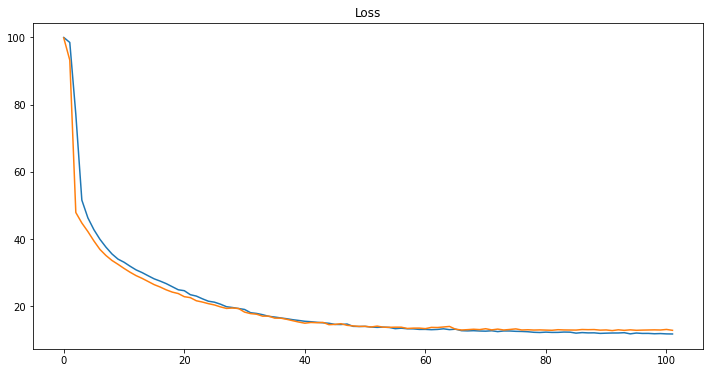

In [41]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show()

In [42]:
model.load_weights(r'/working/best_model_nn_mlp_nlp.hdf5')
model.save(r'/working/nn_4.hdf5')

In [43]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 12.88%


Точность текущей модели выше, чем у наивной модели. Но ниже,чем у CatBoostRegressor. Сохраним результаты для усреднения.

## Predict

In [44]:
sub_predict = model.predict([text_sub_sequences, X_sub])

sample_submission['price'] = sub_predict[:, 0]
sample_submission.to_csv('model_4.csv', index=False)

# округлим
sample_submission['price'] = (sample_submission['price'] // 1000) * 1000
sample_submission.to_csv('model_4_round.csv', index=False)

# Model 5: NN + NLP + CV + Multiple Inputs
multi-input нейронная сеть для анализа табличных данных + текста + cv

In [45]:
df_preproc = preproc_data_default(data)

train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

## PreProc CV

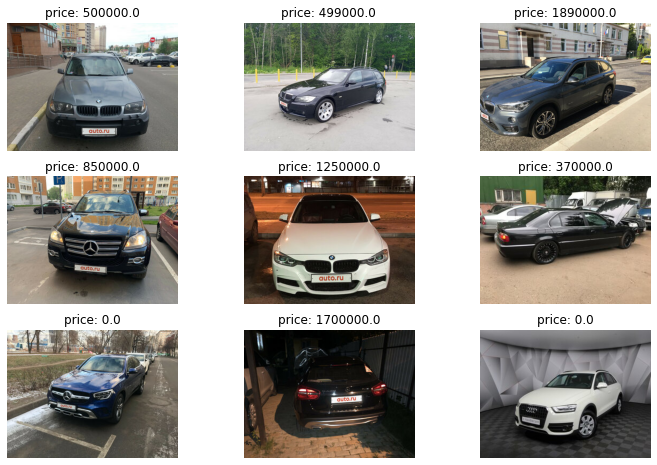

In [46]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize=(12, 8))

random_image = data.sample(n=9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(SF_DIR + 'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [47]:

size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(SF_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5677, 240, 320, 3) dtype uint8
images shape (1002, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


## Аугментация данных

In [48]:
augmentation = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=10, interpolation=1, border_mode=4,
                          always_apply=False, p=0.8),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.2, contrast_limit=0.2),
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.1, contrast_limit=0.1)
    ], p=0.7),
    albumentations.Blur(blur_limit=3, always_apply=False, p=0.5),
    albumentations.HueSaturationValue(
        hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, always_apply=False, p=0.7),
    albumentations.RGBShift(r_shift_limit=20, g_shift_limit=20,
                            b_shift_limit=20, always_apply=False, p=0.7),
    albumentations.ChannelShuffle(p=0.7),
    albumentations.CLAHE(clip_limit=3.0, tile_grid_size=(
        8, 8), always_apply=False, p=0.3)
])

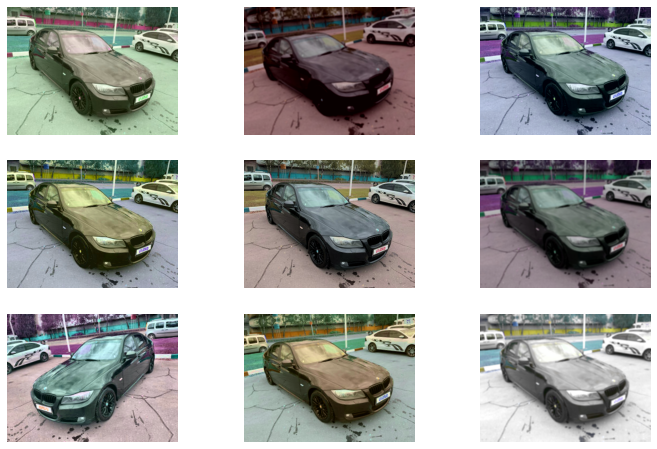

In [49]:
plt.figure(figsize=(12, 8))
for i in range(9):
    img = augmentation(image=images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [50]:
def make_augmentations(images):
    print('применение аугментаций', end='')
    augmented_images = np.empty(images.shape)
    for i in range(images.shape[0]):
        if i % 200 == 0:
            print('.', end='')
        augment_dict = augmentation(image=images[i])
        augmented_image = augment_dict['image']
        augmented_images[i] = augmented_image
    print('')
    return augmented_images

## PrePorc NLP

In [51]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [52]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

In [53]:
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

## Подготовка всех данных для модели

In [54]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

## Нейросеть для анализа изображений без "головы"

In [55]:
# нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(
    weights='imagenet', include_top=False, input_shape=(size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

43941888/43941136 [==============================] - 0s 0us/step


## Нейросеть для табличных данных без "головы"

In [56]:
# строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape=X.shape[1]),
    L.Dense(512, activation='relu'),
    L.Dropout(0.5),
    L.Dense(256, activation='relu'),
    L.Dropout(0.25),
])

## NLP-нейросеть для текстовых данных без "головы"

In [57]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
])

## Multiple Inputs "голова"

In [58]:
# объединяем выходы трех нейросетей
combinedInput = L.concatenate(
    [efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input,
                      tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
____________________________________________________________________________________________

In [59]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE', optimizer=optimizer, metrics=['MAPE'])

In [60]:
earlystop = EarlyStopping(
    monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [earlystop]

## Fit

In [61]:
history = model.fit(train_dataset.batch(4),
                    epochs=100,
                    validation_data=test_dataset.batch(4),
                    callbacks=callbacks_list
                    )

Epoch 1/100
1420/1420 [==============================] - 273s 182ms/step - loss: 47.0413 - MAPE: 47.0413 - val_loss: 24.1243 - val_MAPE: 24.1243
Epoch 2/100
1420/1420 [==============================] - 251s 177ms/step - loss: 25.5618 - MAPE: 25.5618 - val_loss: 46.1368 - val_MAPE: 46.1368
Epoch 3/100
1420/1420 [==============================] - 253s 178ms/step - loss: 21.3766 - MAPE: 21.3766 - val_loss: 17.7780 - val_MAPE: 17.7780
Epoch 4/100
1420/1420 [==============================] - 251s 177ms/step - loss: 18.8771 - MAPE: 18.8771 - val_loss: 15.4919 - val_MAPE: 15.4919
Epoch 5/100
1420/1420 [==============================] - 249s 175ms/step - loss: 17.2572 - MAPE: 17.2572 - val_loss: 14.8987 - val_MAPE: 14.8987
Epoch 6/100
1420/1420 [==============================] - 248s 175ms/step - loss: 16.5593 - MAPE: 16.5593 - val_loss: 14.5921 - val_MAPE: 14.5921
Epoch 7/100
1420/1420 [==============================] - 247s 174ms/step - loss: 15.9107 - MAPE: 15.9107 - val_loss: 14.3329 - val

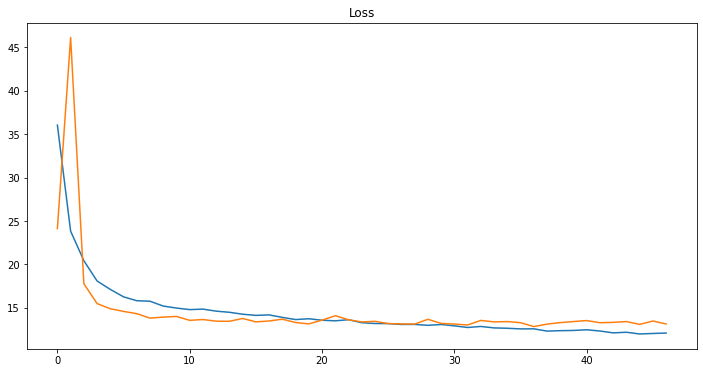

In [62]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [63]:
test_predict_nn3 = model.predict(test_dataset.batch(4))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 12.85%


Точность текущей модели выше, чем у наивной модели. Но ниже,чем у CatBoostRegressor. Сохраним результаты для усреднения.

## Predict

In [64]:
sub_predict = model.predict(sub_dataset.batch(4))
sample_submission['price'] = sub_predict[:, 0]
sample_submission.to_csv('model_5.csv', index=False)

# округлим
sample_submission['price'] = (sample_submission['price'] // 1000) * 1000
sample_submission.to_csv('model_5_round.csv', index=False)

# Model 6

Модель с пробросом признака productionDate

In [65]:
df_preproc = preproc_data_default(data)

train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

## Tabular NN

In [66]:
K.clear_session()

model_mlp = Sequential()
model_mlp.add(L.Dense(1024, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(512, activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.25))

## FEATURE Input

In [67]:
# Iput
productiondate = L.Input(shape=[1], name="productiondate")
# Embeddings layers
emb_productiondate = L.Embedding(
    len(X.productionDate.unique().tolist())+1, 20)(productiondate)
f_productiondate = L.Flatten()(emb_productiondate)

## Head

In [68]:
combinedInput = L.concatenate([model_mlp.output, f_productiondate, ])

# being regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_mlp.input, productiondate], outputs=head)

In [69]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_input (InputLayer)        [(None, 435)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 1024)         446464      dense_input[0][0]                
__________________________________________________________________________________________________
dropout (Dropout)               (None, 1024)         0           dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          524800      dropout[0][0]                    
______________________________________________________________________________________________

In [70]:
optimizer = tf.keras.optimizers.Adam(0.0001)
model.compile(loss='MAPE', optimizer=optimizer, metrics=['MAPE'])

In [71]:
earlystop = EarlyStopping(
    monitor='val_MAPE', patience=150, restore_best_weights=True)
callbacks_list = [earlystop]

## Fit

In [72]:
history = model.fit([X_train, X_train.productionDate.values], y_train,
                    batch_size=512,
                    epochs=3000,  # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(
                        [X_test, X_test.productionDate.values], y_test),
                    callbacks=callbacks_list,
                    verbose=1
                    )

Epoch 1/3000
12/12 [==============================] - 1s 28ms/step - loss: 100.0000 - MAPE: 100.0000 - val_loss: 100.0000 - val_MAPE: 100.0000
Epoch 2/3000
12/12 [==============================] - 0s 9ms/step - loss: 100.0000 - MAPE: 100.0000 - val_loss: 100.0000 - val_MAPE: 100.0000
Epoch 3/3000
12/12 [==============================] - 0s 8ms/step - loss: 100.0000 - MAPE: 100.0000 - val_loss: 100.0000 - val_MAPE: 100.0000
Epoch 4/3000
12/12 [==============================] - 0s 8ms/step - loss: 99.9999 - MAPE: 99.9999 - val_loss: 99.9999 - val_MAPE: 99.9999
Epoch 5/3000
12/12 [==============================] - 0s 8ms/step - loss: 99.9999 - MAPE: 99.9999 - val_loss: 99.9999 - val_MAPE: 99.9999
Epoch 6/3000
12/12 [==============================] - 0s 8ms/step - loss: 99.9998 - MAPE: 99.9998 - val_loss: 99.9997 - val_MAPE: 99.9997
Epoch 7/3000
12/12 [==============================] - 0s 8ms/step - loss: 99.9997 - MAPE: 99.9997 - val_loss: 99.9995 - val_MAPE: 99.9995
Epoch 8/3000
12/12 [=

Epoch 60/3000
12/12 [==============================] - 0s 8ms/step - loss: 45.2675 - MAPE: 45.2675 - val_loss: 43.3135 - val_MAPE: 43.3135
Epoch 61/3000
12/12 [==============================] - 0s 8ms/step - loss: 44.5771 - MAPE: 44.5771 - val_loss: 43.1860 - val_MAPE: 43.1860
Epoch 62/3000
12/12 [==============================] - 0s 8ms/step - loss: 45.0148 - MAPE: 45.0148 - val_loss: 43.0583 - val_MAPE: 43.0583
Epoch 63/3000
12/12 [==============================] - 0s 9ms/step - loss: 44.2364 - MAPE: 44.2364 - val_loss: 42.9248 - val_MAPE: 42.9248
Epoch 64/3000
12/12 [==============================] - 0s 8ms/step - loss: 44.2676 - MAPE: 44.2676 - val_loss: 42.7856 - val_MAPE: 42.7856
Epoch 65/3000
12/12 [==============================] - 0s 8ms/step - loss: 44.2260 - MAPE: 44.2260 - val_loss: 42.6513 - val_MAPE: 42.6513
Epoch 66/3000
12/12 [==============================] - 0s 8ms/step - loss: 44.2447 - MAPE: 44.2447 - val_loss: 42.5175 - val_MAPE: 42.5175
Epoch 67/3000
12/12 [======

Epoch 119/3000
12/12 [==============================] - 0s 8ms/step - loss: 36.2773 - MAPE: 36.2773 - val_loss: 35.4485 - val_MAPE: 35.4485
Epoch 120/3000
12/12 [==============================] - 0s 9ms/step - loss: 36.8759 - MAPE: 36.8759 - val_loss: 35.3464 - val_MAPE: 35.3464
Epoch 121/3000
12/12 [==============================] - 0s 9ms/step - loss: 36.5009 - MAPE: 36.5009 - val_loss: 35.2462 - val_MAPE: 35.2462
Epoch 122/3000
12/12 [==============================] - 0s 9ms/step - loss: 36.7149 - MAPE: 36.7149 - val_loss: 35.1274 - val_MAPE: 35.1274
Epoch 123/3000
12/12 [==============================] - 0s 9ms/step - loss: 36.1926 - MAPE: 36.1926 - val_loss: 35.0261 - val_MAPE: 35.0261
Epoch 124/3000
12/12 [==============================] - 0s 8ms/step - loss: 36.0709 - MAPE: 36.0709 - val_loss: 34.9290 - val_MAPE: 34.9290
Epoch 125/3000
12/12 [==============================] - 0s 8ms/step - loss: 35.9849 - MAPE: 35.9849 - val_loss: 34.8259 - val_MAPE: 34.8259
Epoch 126/3000
12/12

12/12 [==============================] - 0s 8ms/step - loss: 32.0248 - MAPE: 32.0248 - val_loss: 30.7403 - val_MAPE: 30.7403
Epoch 178/3000
12/12 [==============================] - 0s 8ms/step - loss: 32.1814 - MAPE: 32.1814 - val_loss: 30.6840 - val_MAPE: 30.6840
Epoch 179/3000
12/12 [==============================] - 0s 8ms/step - loss: 31.9332 - MAPE: 31.9332 - val_loss: 30.6072 - val_MAPE: 30.6072
Epoch 180/3000
12/12 [==============================] - 0s 8ms/step - loss: 31.8386 - MAPE: 31.8386 - val_loss: 30.5319 - val_MAPE: 30.5319
Epoch 181/3000
12/12 [==============================] - 0s 8ms/step - loss: 31.4505 - MAPE: 31.4505 - val_loss: 30.4547 - val_MAPE: 30.4547
Epoch 182/3000
12/12 [==============================] - 0s 8ms/step - loss: 31.4651 - MAPE: 31.4651 - val_loss: 30.3846 - val_MAPE: 30.3846
Epoch 183/3000
12/12 [==============================] - 0s 8ms/step - loss: 31.6336 - MAPE: 31.6336 - val_loss: 30.3497 - val_MAPE: 30.3497
Epoch 184/3000
12/12 [=============

12/12 [==============================] - 0s 8ms/step - loss: 28.4373 - MAPE: 28.4373 - val_loss: 27.0155 - val_MAPE: 27.0155
Epoch 236/3000
12/12 [==============================] - 0s 8ms/step - loss: 28.5465 - MAPE: 28.5465 - val_loss: 26.9982 - val_MAPE: 26.9982
Epoch 237/3000
12/12 [==============================] - 0s 8ms/step - loss: 28.3877 - MAPE: 28.3877 - val_loss: 26.9554 - val_MAPE: 26.9554
Epoch 238/3000
12/12 [==============================] - 0s 8ms/step - loss: 28.3915 - MAPE: 28.3915 - val_loss: 26.8928 - val_MAPE: 26.8928
Epoch 239/3000
12/12 [==============================] - 0s 8ms/step - loss: 28.0323 - MAPE: 28.0323 - val_loss: 26.8227 - val_MAPE: 26.8227
Epoch 240/3000
12/12 [==============================] - 0s 8ms/step - loss: 27.6054 - MAPE: 27.6054 - val_loss: 26.7581 - val_MAPE: 26.7581
Epoch 241/3000
12/12 [==============================] - 0s 8ms/step - loss: 28.2730 - MAPE: 28.2730 - val_loss: 26.6604 - val_MAPE: 26.6604
Epoch 242/3000
12/12 [=============

12/12 [==============================] - 0s 8ms/step - loss: 25.3898 - MAPE: 25.3898 - val_loss: 24.0145 - val_MAPE: 24.0145
Epoch 294/3000
12/12 [==============================] - 0s 8ms/step - loss: 25.0251 - MAPE: 25.0251 - val_loss: 23.9642 - val_MAPE: 23.9642
Epoch 295/3000
12/12 [==============================] - 0s 8ms/step - loss: 25.4770 - MAPE: 25.4770 - val_loss: 23.9272 - val_MAPE: 23.9272
Epoch 296/3000
12/12 [==============================] - 0s 8ms/step - loss: 24.9461 - MAPE: 24.9461 - val_loss: 23.8522 - val_MAPE: 23.8522
Epoch 297/3000
12/12 [==============================] - 0s 8ms/step - loss: 25.1972 - MAPE: 25.1972 - val_loss: 23.8116 - val_MAPE: 23.8116
Epoch 298/3000
12/12 [==============================] - 0s 8ms/step - loss: 25.2338 - MAPE: 25.2338 - val_loss: 23.7401 - val_MAPE: 23.7401
Epoch 299/3000
12/12 [==============================] - 0s 8ms/step - loss: 24.8162 - MAPE: 24.8162 - val_loss: 23.6976 - val_MAPE: 23.6976
Epoch 300/3000
12/12 [=============

12/12 [==============================] - 0s 8ms/step - loss: 22.8163 - MAPE: 22.8163 - val_loss: 21.5935 - val_MAPE: 21.5935
Epoch 352/3000
12/12 [==============================] - 0s 8ms/step - loss: 22.4384 - MAPE: 22.4384 - val_loss: 21.5785 - val_MAPE: 21.5785
Epoch 353/3000
12/12 [==============================] - 0s 8ms/step - loss: 22.3552 - MAPE: 22.3552 - val_loss: 21.5236 - val_MAPE: 21.5236
Epoch 354/3000
12/12 [==============================] - 0s 8ms/step - loss: 22.2745 - MAPE: 22.2745 - val_loss: 21.5097 - val_MAPE: 21.5097
Epoch 355/3000
12/12 [==============================] - 0s 8ms/step - loss: 22.2910 - MAPE: 22.2910 - val_loss: 21.4584 - val_MAPE: 21.4584
Epoch 356/3000
12/12 [==============================] - 0s 10ms/step - loss: 22.3958 - MAPE: 22.3958 - val_loss: 21.4284 - val_MAPE: 21.4284
Epoch 357/3000
12/12 [==============================] - 0s 8ms/step - loss: 22.3335 - MAPE: 22.3335 - val_loss: 21.4308 - val_MAPE: 21.4308
Epoch 358/3000
12/12 [============

12/12 [==============================] - 0s 8ms/step - loss: 20.4733 - MAPE: 20.4733 - val_loss: 19.9682 - val_MAPE: 19.9682
Epoch 410/3000
12/12 [==============================] - 0s 8ms/step - loss: 20.2993 - MAPE: 20.2993 - val_loss: 19.9376 - val_MAPE: 19.9376
Epoch 411/3000
12/12 [==============================] - 0s 8ms/step - loss: 20.8239 - MAPE: 20.8239 - val_loss: 19.9227 - val_MAPE: 19.9227
Epoch 412/3000
12/12 [==============================] - 0s 8ms/step - loss: 20.6231 - MAPE: 20.6231 - val_loss: 19.8823 - val_MAPE: 19.8823
Epoch 413/3000
12/12 [==============================] - 0s 8ms/step - loss: 20.3570 - MAPE: 20.3570 - val_loss: 19.8529 - val_MAPE: 19.8529
Epoch 414/3000
12/12 [==============================] - 0s 9ms/step - loss: 20.6001 - MAPE: 20.6001 - val_loss: 19.8307 - val_MAPE: 19.8307
Epoch 415/3000
12/12 [==============================] - 0s 8ms/step - loss: 20.6311 - MAPE: 20.6311 - val_loss: 19.7918 - val_MAPE: 19.7918
Epoch 416/3000
12/12 [=============

12/12 [==============================] - 0s 8ms/step - loss: 18.7325 - MAPE: 18.7325 - val_loss: 18.5649 - val_MAPE: 18.5649
Epoch 468/3000
12/12 [==============================] - 0s 10ms/step - loss: 19.0991 - MAPE: 19.0991 - val_loss: 18.5444 - val_MAPE: 18.5444
Epoch 469/3000
12/12 [==============================] - 0s 8ms/step - loss: 18.5061 - MAPE: 18.5061 - val_loss: 18.5034 - val_MAPE: 18.5034
Epoch 470/3000
12/12 [==============================] - 0s 8ms/step - loss: 18.7405 - MAPE: 18.7405 - val_loss: 18.4718 - val_MAPE: 18.4718
Epoch 471/3000
12/12 [==============================] - 0s 8ms/step - loss: 19.1516 - MAPE: 19.1516 - val_loss: 18.4475 - val_MAPE: 18.4475
Epoch 472/3000
12/12 [==============================] - 0s 8ms/step - loss: 18.7450 - MAPE: 18.7450 - val_loss: 18.4362 - val_MAPE: 18.4362
Epoch 473/3000
12/12 [==============================] - 0s 8ms/step - loss: 18.7142 - MAPE: 18.7142 - val_loss: 18.4345 - val_MAPE: 18.4345
Epoch 474/3000
12/12 [============

12/12 [==============================] - 0s 11ms/step - loss: 17.5622 - MAPE: 17.5622 - val_loss: 17.3884 - val_MAPE: 17.3884
Epoch 526/3000
12/12 [==============================] - 0s 11ms/step - loss: 17.4014 - MAPE: 17.4014 - val_loss: 17.3555 - val_MAPE: 17.3555
Epoch 527/3000
12/12 [==============================] - 0s 8ms/step - loss: 17.1460 - MAPE: 17.1460 - val_loss: 17.3250 - val_MAPE: 17.3250
Epoch 528/3000
12/12 [==============================] - 0s 8ms/step - loss: 17.4694 - MAPE: 17.4694 - val_loss: 17.3061 - val_MAPE: 17.3061
Epoch 529/3000
12/12 [==============================] - 0s 8ms/step - loss: 17.4999 - MAPE: 17.4999 - val_loss: 17.2909 - val_MAPE: 17.2909
Epoch 530/3000
12/12 [==============================] - 0s 8ms/step - loss: 17.1119 - MAPE: 17.1119 - val_loss: 17.2904 - val_MAPE: 17.2904
Epoch 531/3000
12/12 [==============================] - 0s 8ms/step - loss: 17.0203 - MAPE: 17.0203 - val_loss: 17.2756 - val_MAPE: 17.2756
Epoch 532/3000
12/12 [===========

12/12 [==============================] - 0s 8ms/step - loss: 16.1059 - MAPE: 16.1059 - val_loss: 16.3120 - val_MAPE: 16.3120
Epoch 584/3000
12/12 [==============================] - 0s 8ms/step - loss: 16.3099 - MAPE: 16.3099 - val_loss: 16.2889 - val_MAPE: 16.2889
Epoch 585/3000
12/12 [==============================] - 0s 8ms/step - loss: 16.5002 - MAPE: 16.5002 - val_loss: 16.2902 - val_MAPE: 16.2902
Epoch 586/3000
12/12 [==============================] - 0s 8ms/step - loss: 16.4217 - MAPE: 16.4217 - val_loss: 16.2920 - val_MAPE: 16.2920
Epoch 587/3000
12/12 [==============================] - 0s 8ms/step - loss: 16.0295 - MAPE: 16.0295 - val_loss: 16.2721 - val_MAPE: 16.2721
Epoch 588/3000
12/12 [==============================] - 0s 8ms/step - loss: 16.2118 - MAPE: 16.2118 - val_loss: 16.2348 - val_MAPE: 16.2348
Epoch 589/3000
12/12 [==============================] - 0s 8ms/step - loss: 16.4528 - MAPE: 16.4528 - val_loss: 16.2157 - val_MAPE: 16.2157
Epoch 590/3000
12/12 [=============

12/12 [==============================] - 0s 8ms/step - loss: 15.2824 - MAPE: 15.2824 - val_loss: 15.4837 - val_MAPE: 15.4837
Epoch 642/3000
12/12 [==============================] - 0s 8ms/step - loss: 15.3494 - MAPE: 15.3494 - val_loss: 15.4675 - val_MAPE: 15.4675
Epoch 643/3000
12/12 [==============================] - 0s 8ms/step - loss: 15.3511 - MAPE: 15.3511 - val_loss: 15.4449 - val_MAPE: 15.4449
Epoch 644/3000
12/12 [==============================] - 0s 8ms/step - loss: 15.2155 - MAPE: 15.2155 - val_loss: 15.4156 - val_MAPE: 15.4156
Epoch 645/3000
12/12 [==============================] - 0s 8ms/step - loss: 15.2656 - MAPE: 15.2656 - val_loss: 15.4144 - val_MAPE: 15.4144
Epoch 646/3000
12/12 [==============================] - 0s 8ms/step - loss: 15.4963 - MAPE: 15.4963 - val_loss: 15.4029 - val_MAPE: 15.4029
Epoch 647/3000
12/12 [==============================] - 0s 8ms/step - loss: 15.2925 - MAPE: 15.2925 - val_loss: 15.3904 - val_MAPE: 15.3904
Epoch 648/3000
12/12 [=============

12/12 [==============================] - 0s 8ms/step - loss: 14.6655 - MAPE: 14.6655 - val_loss: 14.8001 - val_MAPE: 14.8001
Epoch 700/3000
12/12 [==============================] - 0s 8ms/step - loss: 14.6373 - MAPE: 14.6373 - val_loss: 14.7809 - val_MAPE: 14.7809
Epoch 701/3000
12/12 [==============================] - 0s 8ms/step - loss: 14.6278 - MAPE: 14.6278 - val_loss: 14.7935 - val_MAPE: 14.7935
Epoch 702/3000
12/12 [==============================] - 0s 8ms/step - loss: 14.5925 - MAPE: 14.5925 - val_loss: 14.7819 - val_MAPE: 14.7819
Epoch 703/3000
12/12 [==============================] - 0s 8ms/step - loss: 14.7338 - MAPE: 14.7338 - val_loss: 14.7767 - val_MAPE: 14.7767
Epoch 704/3000
12/12 [==============================] - 0s 8ms/step - loss: 14.6191 - MAPE: 14.6191 - val_loss: 14.7523 - val_MAPE: 14.7523
Epoch 705/3000
12/12 [==============================] - 0s 8ms/step - loss: 14.6405 - MAPE: 14.6405 - val_loss: 14.7302 - val_MAPE: 14.7302
Epoch 706/3000
12/12 [=============

12/12 [==============================] - 0s 8ms/step - loss: 14.3604 - MAPE: 14.3604 - val_loss: 14.3082 - val_MAPE: 14.3082
Epoch 758/3000
12/12 [==============================] - 0s 8ms/step - loss: 14.0364 - MAPE: 14.0364 - val_loss: 14.3061 - val_MAPE: 14.3061
Epoch 759/3000
12/12 [==============================] - 0s 8ms/step - loss: 14.0747 - MAPE: 14.0747 - val_loss: 14.2934 - val_MAPE: 14.2934
Epoch 760/3000
12/12 [==============================] - 0s 8ms/step - loss: 13.9842 - MAPE: 13.9842 - val_loss: 14.2952 - val_MAPE: 14.2952
Epoch 761/3000
12/12 [==============================] - 0s 8ms/step - loss: 14.2532 - MAPE: 14.2532 - val_loss: 14.3002 - val_MAPE: 14.3002
Epoch 762/3000
12/12 [==============================] - 0s 8ms/step - loss: 14.5602 - MAPE: 14.5602 - val_loss: 14.2907 - val_MAPE: 14.2907
Epoch 763/3000
12/12 [==============================] - 0s 8ms/step - loss: 13.8803 - MAPE: 13.8803 - val_loss: 14.2826 - val_MAPE: 14.2826
Epoch 764/3000
12/12 [=============

12/12 [==============================] - 0s 9ms/step - loss: 13.8561 - MAPE: 13.8561 - val_loss: 13.9171 - val_MAPE: 13.9171
Epoch 816/3000
12/12 [==============================] - 0s 9ms/step - loss: 13.9509 - MAPE: 13.9509 - val_loss: 13.8869 - val_MAPE: 13.8869
Epoch 817/3000
12/12 [==============================] - 0s 9ms/step - loss: 14.0461 - MAPE: 14.0461 - val_loss: 13.8725 - val_MAPE: 13.8725
Epoch 818/3000
12/12 [==============================] - 0s 9ms/step - loss: 13.6549 - MAPE: 13.6549 - val_loss: 13.8603 - val_MAPE: 13.8603
Epoch 819/3000
12/12 [==============================] - 0s 9ms/step - loss: 13.6881 - MAPE: 13.6881 - val_loss: 13.8677 - val_MAPE: 13.8677
Epoch 820/3000
12/12 [==============================] - 0s 8ms/step - loss: 13.6370 - MAPE: 13.6370 - val_loss: 13.8627 - val_MAPE: 13.8627
Epoch 821/3000
12/12 [==============================] - 0s 8ms/step - loss: 13.8373 - MAPE: 13.8373 - val_loss: 13.8653 - val_MAPE: 13.8653
Epoch 822/3000
12/12 [=============

12/12 [==============================] - 0s 8ms/step - loss: 13.6680 - MAPE: 13.6680 - val_loss: 13.6523 - val_MAPE: 13.6523
Epoch 874/3000
12/12 [==============================] - 0s 8ms/step - loss: 13.1841 - MAPE: 13.1841 - val_loss: 13.6397 - val_MAPE: 13.6397
Epoch 875/3000
12/12 [==============================] - 0s 8ms/step - loss: 13.5724 - MAPE: 13.5724 - val_loss: 13.6343 - val_MAPE: 13.6343
Epoch 876/3000
12/12 [==============================] - 0s 8ms/step - loss: 13.2394 - MAPE: 13.2394 - val_loss: 13.6155 - val_MAPE: 13.6155
Epoch 877/3000
12/12 [==============================] - 0s 8ms/step - loss: 13.0413 - MAPE: 13.0413 - val_loss: 13.6146 - val_MAPE: 13.6146
Epoch 878/3000
12/12 [==============================] - 0s 8ms/step - loss: 13.4222 - MAPE: 13.4222 - val_loss: 13.5898 - val_MAPE: 13.5898
Epoch 879/3000
12/12 [==============================] - 0s 8ms/step - loss: 13.3382 - MAPE: 13.3382 - val_loss: 13.5816 - val_MAPE: 13.5816
Epoch 880/3000
12/12 [=============

12/12 [==============================] - 0s 8ms/step - loss: 13.1667 - MAPE: 13.1667 - val_loss: 13.4433 - val_MAPE: 13.4433
Epoch 932/3000
12/12 [==============================] - 0s 8ms/step - loss: 13.2698 - MAPE: 13.2698 - val_loss: 13.4338 - val_MAPE: 13.4338
Epoch 933/3000
12/12 [==============================] - 0s 8ms/step - loss: 13.3762 - MAPE: 13.3762 - val_loss: 13.4358 - val_MAPE: 13.4358
Epoch 934/3000
12/12 [==============================] - 0s 8ms/step - loss: 13.1158 - MAPE: 13.1158 - val_loss: 13.4302 - val_MAPE: 13.4302
Epoch 935/3000
12/12 [==============================] - 0s 8ms/step - loss: 13.2174 - MAPE: 13.2174 - val_loss: 13.4554 - val_MAPE: 13.4554
Epoch 936/3000
12/12 [==============================] - 0s 8ms/step - loss: 13.3251 - MAPE: 13.3251 - val_loss: 13.4603 - val_MAPE: 13.4603
Epoch 937/3000
12/12 [==============================] - 0s 8ms/step - loss: 12.9939 - MAPE: 12.9939 - val_loss: 13.4565 - val_MAPE: 13.4565
Epoch 938/3000
12/12 [=============

12/12 [==============================] - 0s 8ms/step - loss: 12.7847 - MAPE: 12.7847 - val_loss: 13.2977 - val_MAPE: 13.2977
Epoch 990/3000
12/12 [==============================] - 0s 8ms/step - loss: 13.0444 - MAPE: 13.0444 - val_loss: 13.2789 - val_MAPE: 13.2789
Epoch 991/3000
12/12 [==============================] - 0s 8ms/step - loss: 12.7014 - MAPE: 12.7014 - val_loss: 13.2818 - val_MAPE: 13.2818
Epoch 992/3000
12/12 [==============================] - 0s 8ms/step - loss: 12.8564 - MAPE: 12.8564 - val_loss: 13.2745 - val_MAPE: 13.2745
Epoch 993/3000
12/12 [==============================] - 0s 8ms/step - loss: 12.7367 - MAPE: 12.7367 - val_loss: 13.2889 - val_MAPE: 13.2889
Epoch 994/3000
12/12 [==============================] - 0s 8ms/step - loss: 12.9147 - MAPE: 12.9147 - val_loss: 13.2781 - val_MAPE: 13.2781
Epoch 995/3000
12/12 [==============================] - 0s 8ms/step - loss: 12.8985 - MAPE: 12.8985 - val_loss: 13.2877 - val_MAPE: 13.2877
Epoch 996/3000
12/12 [=============

12/12 [==============================] - 0s 13ms/step - loss: 12.9710 - MAPE: 12.9710 - val_loss: 13.1902 - val_MAPE: 13.1902
Epoch 1048/3000
12/12 [==============================] - 0s 13ms/step - loss: 12.8818 - MAPE: 12.8818 - val_loss: 13.1915 - val_MAPE: 13.1915
Epoch 1049/3000
12/12 [==============================] - 0s 13ms/step - loss: 12.6593 - MAPE: 12.6593 - val_loss: 13.2212 - val_MAPE: 13.2212
Epoch 1050/3000
12/12 [==============================] - 0s 11ms/step - loss: 12.7198 - MAPE: 12.7198 - val_loss: 13.1846 - val_MAPE: 13.1846
Epoch 1051/3000
12/12 [==============================] - 0s 8ms/step - loss: 12.8397 - MAPE: 12.8397 - val_loss: 13.1894 - val_MAPE: 13.1894
Epoch 1052/3000
12/12 [==============================] - 0s 8ms/step - loss: 12.7459 - MAPE: 12.7459 - val_loss: 13.1731 - val_MAPE: 13.1731
Epoch 1053/3000
12/12 [==============================] - 0s 8ms/step - loss: 12.9157 - MAPE: 12.9157 - val_loss: 13.1719 - val_MAPE: 13.1719
Epoch 1054/3000
12/12 [==

12/12 [==============================] - 0s 8ms/step - loss: 12.6618 - MAPE: 12.6618 - val_loss: 13.0858 - val_MAPE: 13.0858
Epoch 1106/3000
12/12 [==============================] - 0s 8ms/step - loss: 12.5595 - MAPE: 12.5595 - val_loss: 13.0823 - val_MAPE: 13.0823
Epoch 1107/3000
12/12 [==============================] - 0s 8ms/step - loss: 12.7815 - MAPE: 12.7815 - val_loss: 13.0996 - val_MAPE: 13.0996
Epoch 1108/3000
12/12 [==============================] - 0s 8ms/step - loss: 12.7462 - MAPE: 12.7462 - val_loss: 13.0882 - val_MAPE: 13.0882
Epoch 1109/3000
12/12 [==============================] - 0s 9ms/step - loss: 12.5641 - MAPE: 12.5641 - val_loss: 13.0879 - val_MAPE: 13.0879
Epoch 1110/3000
12/12 [==============================] - 0s 8ms/step - loss: 12.8210 - MAPE: 12.8210 - val_loss: 13.1323 - val_MAPE: 13.1323
Epoch 1111/3000
12/12 [==============================] - 0s 8ms/step - loss: 12.5628 - MAPE: 12.5628 - val_loss: 13.1061 - val_MAPE: 13.1061
Epoch 1112/3000
12/12 [======

12/12 [==============================] - 0s 8ms/step - loss: 12.5018 - MAPE: 12.5018 - val_loss: 12.9658 - val_MAPE: 12.9658
Epoch 1164/3000
12/12 [==============================] - 0s 8ms/step - loss: 12.4746 - MAPE: 12.4746 - val_loss: 12.9928 - val_MAPE: 12.9928
Epoch 1165/3000
12/12 [==============================] - 0s 8ms/step - loss: 12.3948 - MAPE: 12.3948 - val_loss: 12.9698 - val_MAPE: 12.9698
Epoch 1166/3000
12/12 [==============================] - 0s 8ms/step - loss: 12.5590 - MAPE: 12.5590 - val_loss: 12.9738 - val_MAPE: 12.9738
Epoch 1167/3000
12/12 [==============================] - 0s 8ms/step - loss: 12.5339 - MAPE: 12.5339 - val_loss: 12.9876 - val_MAPE: 12.9876
Epoch 1168/3000
12/12 [==============================] - 0s 8ms/step - loss: 12.4494 - MAPE: 12.4494 - val_loss: 12.9815 - val_MAPE: 12.9815
Epoch 1169/3000
12/12 [==============================] - 0s 8ms/step - loss: 12.5291 - MAPE: 12.5291 - val_loss: 12.9979 - val_MAPE: 12.9979
Epoch 1170/3000
12/12 [======

12/12 [==============================] - 0s 8ms/step - loss: 12.3080 - MAPE: 12.3080 - val_loss: 12.9508 - val_MAPE: 12.9508
Epoch 1222/3000
12/12 [==============================] - ETA: 0s - loss: 12.1848 - MAPE: 12.18 - 0s 8ms/step - loss: 12.2599 - MAPE: 12.2599 - val_loss: 12.9555 - val_MAPE: 12.9555
Epoch 1223/3000
12/12 [==============================] - 0s 8ms/step - loss: 12.2727 - MAPE: 12.2727 - val_loss: 12.9780 - val_MAPE: 12.9780
Epoch 1224/3000
12/12 [==============================] - 0s 8ms/step - loss: 12.2138 - MAPE: 12.2138 - val_loss: 12.9524 - val_MAPE: 12.9524
Epoch 1225/3000
12/12 [==============================] - 0s 8ms/step - loss: 12.3305 - MAPE: 12.3305 - val_loss: 12.9436 - val_MAPE: 12.9436
Epoch 1226/3000
12/12 [==============================] - 0s 8ms/step - loss: 12.4492 - MAPE: 12.4492 - val_loss: 12.9835 - val_MAPE: 12.9835
Epoch 1227/3000
12/12 [==============================] - 0s 8ms/step - loss: 12.2091 - MAPE: 12.2091 - val_loss: 12.9328 - val_MAP

Epoch 1279/3000
12/12 [==============================] - 0s 8ms/step - loss: 12.0665 - MAPE: 12.0665 - val_loss: 12.8576 - val_MAPE: 12.8576
Epoch 1280/3000
12/12 [==============================] - 0s 8ms/step - loss: 12.1217 - MAPE: 12.1217 - val_loss: 12.8763 - val_MAPE: 12.8763
Epoch 1281/3000
12/12 [==============================] - 0s 8ms/step - loss: 12.0847 - MAPE: 12.0847 - val_loss: 12.8890 - val_MAPE: 12.8890
Epoch 1282/3000
12/12 [==============================] - 0s 8ms/step - loss: 12.4018 - MAPE: 12.4018 - val_loss: 12.9107 - val_MAPE: 12.9107
Epoch 1283/3000
12/12 [==============================] - 0s 8ms/step - loss: 12.1079 - MAPE: 12.1079 - val_loss: 12.9132 - val_MAPE: 12.9132
Epoch 1284/3000
12/12 [==============================] - 0s 8ms/step - loss: 12.0381 - MAPE: 12.0381 - val_loss: 12.9032 - val_MAPE: 12.9032
Epoch 1285/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.9532 - MAPE: 11.9532 - val_loss: 12.8925 - val_MAPE: 12.8925
Epoch 1286/30

12/12 [==============================] - 0s 8ms/step - loss: 12.0592 - MAPE: 12.0592 - val_loss: 12.8103 - val_MAPE: 12.8103
Epoch 1338/3000
12/12 [==============================] - 0s 8ms/step - loss: 12.0218 - MAPE: 12.0218 - val_loss: 12.7987 - val_MAPE: 12.7987
Epoch 1339/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.9937 - MAPE: 11.9937 - val_loss: 12.7925 - val_MAPE: 12.7925
Epoch 1340/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.9664 - MAPE: 11.9664 - val_loss: 12.8088 - val_MAPE: 12.8088
Epoch 1341/3000
12/12 [==============================] - 0s 8ms/step - loss: 12.1498 - MAPE: 12.1498 - val_loss: 12.7840 - val_MAPE: 12.7840
Epoch 1342/3000
12/12 [==============================] - 0s 8ms/step - loss: 12.0327 - MAPE: 12.0327 - val_loss: 12.8037 - val_MAPE: 12.8037
Epoch 1343/3000
12/12 [==============================] - 0s 8ms/step - loss: 12.2513 - MAPE: 12.2513 - val_loss: 12.8215 - val_MAPE: 12.8215
Epoch 1344/3000
12/12 [======

12/12 [==============================] - 0s 8ms/step - loss: 12.0326 - MAPE: 12.0326 - val_loss: 12.7695 - val_MAPE: 12.7695
Epoch 1396/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.8389 - MAPE: 11.8389 - val_loss: 12.7615 - val_MAPE: 12.7615
Epoch 1397/3000
12/12 [==============================] - 0s 11ms/step - loss: 11.8321 - MAPE: 11.8321 - val_loss: 12.7434 - val_MAPE: 12.7434
Epoch 1398/3000
12/12 [==============================] - 0s 8ms/step - loss: 12.2217 - MAPE: 12.2217 - val_loss: 12.7423 - val_MAPE: 12.7423
Epoch 1399/3000
12/12 [==============================] - 0s 9ms/step - loss: 11.8322 - MAPE: 11.8322 - val_loss: 12.7474 - val_MAPE: 12.7474
Epoch 1400/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.8211 - MAPE: 11.8211 - val_loss: 12.7465 - val_MAPE: 12.7465
Epoch 1401/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.9234 - MAPE: 11.9234 - val_loss: 12.7454 - val_MAPE: 12.7454
Epoch 1402/3000
12/12 [=====

12/12 [==============================] - 0s 8ms/step - loss: 11.8877 - MAPE: 11.8877 - val_loss: 12.7184 - val_MAPE: 12.7184
Epoch 1454/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.9478 - MAPE: 11.9478 - val_loss: 12.7271 - val_MAPE: 12.7271
Epoch 1455/3000
12/12 [==============================] - 0s 9ms/step - loss: 11.7484 - MAPE: 11.7484 - val_loss: 12.6881 - val_MAPE: 12.6881
Epoch 1456/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.8188 - MAPE: 11.8188 - val_loss: 12.6949 - val_MAPE: 12.6949
Epoch 1457/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.9832 - MAPE: 11.9832 - val_loss: 12.7136 - val_MAPE: 12.7136
Epoch 1458/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.7035 - MAPE: 11.7035 - val_loss: 12.7267 - val_MAPE: 12.7267
Epoch 1459/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.6511 - MAPE: 11.6511 - val_loss: 12.7058 - val_MAPE: 12.7058
Epoch 1460/3000
12/12 [======

12/12 [==============================] - 0s 9ms/step - loss: 11.6597 - MAPE: 11.6597 - val_loss: 12.6732 - val_MAPE: 12.6732
Epoch 1512/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.8204 - MAPE: 11.8204 - val_loss: 12.6953 - val_MAPE: 12.6953
Epoch 1513/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.9129 - MAPE: 11.9129 - val_loss: 12.6560 - val_MAPE: 12.6560
Epoch 1514/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.5059 - MAPE: 11.5059 - val_loss: 12.6508 - val_MAPE: 12.6508
Epoch 1515/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.8517 - MAPE: 11.8517 - val_loss: 12.6673 - val_MAPE: 12.6673
Epoch 1516/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.7598 - MAPE: 11.7598 - val_loss: 12.6746 - val_MAPE: 12.6746
Epoch 1517/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.6177 - MAPE: 11.6177 - val_loss: 12.6826 - val_MAPE: 12.6826
Epoch 1518/3000
12/12 [======

12/12 [==============================] - 0s 9ms/step - loss: 11.5608 - MAPE: 11.5608 - val_loss: 12.6950 - val_MAPE: 12.6950
Epoch 1570/3000
12/12 [==============================] - 0s 17ms/step - loss: 11.7571 - MAPE: 11.7571 - val_loss: 12.6719 - val_MAPE: 12.6719
Epoch 1571/3000
12/12 [==============================] - 0s 13ms/step - loss: 11.7909 - MAPE: 11.7909 - val_loss: 12.6735 - val_MAPE: 12.6735
Epoch 1572/3000
12/12 [==============================] - 0s 13ms/step - loss: 11.4986 - MAPE: 11.4986 - val_loss: 12.6714 - val_MAPE: 12.6714
Epoch 1573/3000
12/12 [==============================] - 0s 12ms/step - loss: 11.6371 - MAPE: 11.6371 - val_loss: 12.6391 - val_MAPE: 12.6391
Epoch 1574/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.5665 - MAPE: 11.5665 - val_loss: 12.6611 - val_MAPE: 12.6611
Epoch 1575/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.7992 - MAPE: 11.7992 - val_loss: 12.6676 - val_MAPE: 12.6676
Epoch 1576/3000
12/12 [==

12/12 [==============================] - 0s 8ms/step - loss: 11.7663 - MAPE: 11.7663 - val_loss: 12.6244 - val_MAPE: 12.6244
Epoch 1628/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.5457 - MAPE: 11.5457 - val_loss: 12.6369 - val_MAPE: 12.6369
Epoch 1629/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.4169 - MAPE: 11.4169 - val_loss: 12.6166 - val_MAPE: 12.6166
Epoch 1630/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.3517 - MAPE: 11.3517 - val_loss: 12.6344 - val_MAPE: 12.6344
Epoch 1631/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.7249 - MAPE: 11.7249 - val_loss: 12.6123 - val_MAPE: 12.6123
Epoch 1632/3000
12/12 [==============================] - 0s 9ms/step - loss: 11.5790 - MAPE: 11.5790 - val_loss: 12.6180 - val_MAPE: 12.6180
Epoch 1633/3000
12/12 [==============================] - 0s 9ms/step - loss: 11.8929 - MAPE: 11.8929 - val_loss: 12.6412 - val_MAPE: 12.6412
Epoch 1634/3000
12/12 [======

12/12 [==============================] - 0s 8ms/step - loss: 11.5491 - MAPE: 11.5491 - val_loss: 12.6338 - val_MAPE: 12.6338
Epoch 1686/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.3457 - MAPE: 11.3457 - val_loss: 12.6215 - val_MAPE: 12.6215
Epoch 1687/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.4152 - MAPE: 11.4152 - val_loss: 12.6196 - val_MAPE: 12.6196
Epoch 1688/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.4574 - MAPE: 11.4574 - val_loss: 12.6344 - val_MAPE: 12.6344
Epoch 1689/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.5409 - MAPE: 11.5409 - val_loss: 12.6148 - val_MAPE: 12.6148
Epoch 1690/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.6179 - MAPE: 11.6179 - val_loss: 12.6145 - val_MAPE: 12.6145
Epoch 1691/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.2488 - MAPE: 11.2488 - val_loss: 12.6344 - val_MAPE: 12.6344
Epoch 1692/3000
12/12 [======

12/12 [==============================] - 0s 8ms/step - loss: 11.3718 - MAPE: 11.3718 - val_loss: 12.6157 - val_MAPE: 12.6157
Epoch 1744/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.4075 - MAPE: 11.4075 - val_loss: 12.6152 - val_MAPE: 12.6152
Epoch 1745/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.1158 - MAPE: 11.1158 - val_loss: 12.6325 - val_MAPE: 12.6325
Epoch 1746/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.5381 - MAPE: 11.5381 - val_loss: 12.6228 - val_MAPE: 12.6228
Epoch 1747/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.2848 - MAPE: 11.2848 - val_loss: 12.6325 - val_MAPE: 12.6325
Epoch 1748/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.4151 - MAPE: 11.4151 - val_loss: 12.6381 - val_MAPE: 12.6381
Epoch 1749/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.2935 - MAPE: 11.2935 - val_loss: 12.6419 - val_MAPE: 12.6419
Epoch 1750/3000
12/12 [======

12/12 [==============================] - 0s 8ms/step - loss: 11.4536 - MAPE: 11.4536 - val_loss: 12.6182 - val_MAPE: 12.6182
Epoch 1802/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.2565 - MAPE: 11.2565 - val_loss: 12.6221 - val_MAPE: 12.6221
Epoch 1803/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.0644 - MAPE: 11.0644 - val_loss: 12.5924 - val_MAPE: 12.5924
Epoch 1804/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.4775 - MAPE: 11.4775 - val_loss: 12.6086 - val_MAPE: 12.6086
Epoch 1805/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.1976 - MAPE: 11.1976 - val_loss: 12.6075 - val_MAPE: 12.6075
Epoch 1806/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.2844 - MAPE: 11.2844 - val_loss: 12.6078 - val_MAPE: 12.6078
Epoch 1807/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.3979 - MAPE: 11.3979 - val_loss: 12.6104 - val_MAPE: 12.6104
Epoch 1808/3000
12/12 [======

12/12 [==============================] - 0s 8ms/step - loss: 11.0398 - MAPE: 11.0398 - val_loss: 12.6028 - val_MAPE: 12.6028
Epoch 1860/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.3261 - MAPE: 11.3261 - val_loss: 12.5791 - val_MAPE: 12.5791
Epoch 1861/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.1913 - MAPE: 11.1913 - val_loss: 12.5982 - val_MAPE: 12.5982
Epoch 1862/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.3794 - MAPE: 11.3794 - val_loss: 12.5894 - val_MAPE: 12.5894
Epoch 1863/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.4909 - MAPE: 11.4909 - val_loss: 12.5836 - val_MAPE: 12.5836
Epoch 1864/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.5332 - MAPE: 11.5332 - val_loss: 12.5846 - val_MAPE: 12.5846
Epoch 1865/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.4003 - MAPE: 11.4003 - val_loss: 12.5835 - val_MAPE: 12.5835
Epoch 1866/3000
12/12 [======

12/12 [==============================] - 0s 8ms/step - loss: 11.1818 - MAPE: 11.1818 - val_loss: 12.6074 - val_MAPE: 12.6074
Epoch 1918/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.1911 - MAPE: 11.1911 - val_loss: 12.5793 - val_MAPE: 12.5793
Epoch 1919/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.2904 - MAPE: 11.2904 - val_loss: 12.5784 - val_MAPE: 12.5784
Epoch 1920/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.0933 - MAPE: 11.0933 - val_loss: 12.5720 - val_MAPE: 12.5720
Epoch 1921/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.3293 - MAPE: 11.3293 - val_loss: 12.5600 - val_MAPE: 12.5600
Epoch 1922/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.1846 - MAPE: 11.1846 - val_loss: 12.5820 - val_MAPE: 12.5820
Epoch 1923/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.1677 - MAPE: 11.1677 - val_loss: 12.5742 - val_MAPE: 12.5742
Epoch 1924/3000
12/12 [======

12/12 [==============================] - 0s 8ms/step - loss: 11.1654 - MAPE: 11.1654 - val_loss: 12.5671 - val_MAPE: 12.5671
Epoch 1976/3000
12/12 [==============================] - 0s 11ms/step - loss: 11.1578 - MAPE: 11.1578 - val_loss: 12.5612 - val_MAPE: 12.5612
Epoch 1977/3000
12/12 [==============================] - 0s 9ms/step - loss: 11.1963 - MAPE: 11.1963 - val_loss: 12.5707 - val_MAPE: 12.5707
Epoch 1978/3000
12/12 [==============================] - 0s 9ms/step - loss: 11.3504 - MAPE: 11.3504 - val_loss: 12.5739 - val_MAPE: 12.5739
Epoch 1979/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.1479 - MAPE: 11.1479 - val_loss: 12.5669 - val_MAPE: 12.5669
Epoch 1980/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.0911 - MAPE: 11.0911 - val_loss: 12.5818 - val_MAPE: 12.5818
Epoch 1981/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.2449 - MAPE: 11.2449 - val_loss: 12.5686 - val_MAPE: 12.5686
Epoch 1982/3000
12/12 [=====

12/12 [==============================] - 0s 8ms/step - loss: 11.0748 - MAPE: 11.0748 - val_loss: 12.5722 - val_MAPE: 12.5722
Epoch 2034/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.3442 - MAPE: 11.3442 - val_loss: 12.5644 - val_MAPE: 12.5644
Epoch 2035/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.0467 - MAPE: 11.0467 - val_loss: 12.5745 - val_MAPE: 12.5745
Epoch 2036/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.0875 - MAPE: 11.0875 - val_loss: 12.5942 - val_MAPE: 12.5942
Epoch 2037/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.2070 - MAPE: 11.2070 - val_loss: 12.5823 - val_MAPE: 12.5823
Epoch 2038/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.0633 - MAPE: 11.0633 - val_loss: 12.5923 - val_MAPE: 12.5923
Epoch 2039/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.0582 - MAPE: 11.0582 - val_loss: 12.5987 - val_MAPE: 12.5987
Epoch 2040/3000
12/12 [======

12/12 [==============================] - 0s 8ms/step - loss: 11.0556 - MAPE: 11.0556 - val_loss: 12.5822 - val_MAPE: 12.5822
Epoch 2092/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.1377 - MAPE: 11.1377 - val_loss: 12.5697 - val_MAPE: 12.5697
Epoch 2093/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.2198 - MAPE: 11.2198 - val_loss: 12.5709 - val_MAPE: 12.5709
Epoch 2094/3000
12/12 [==============================] - 0s 8ms/step - loss: 10.7207 - MAPE: 10.7207 - val_loss: 12.5514 - val_MAPE: 12.5514
Epoch 2095/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.1216 - MAPE: 11.1216 - val_loss: 12.5468 - val_MAPE: 12.5468
Epoch 2096/3000
12/12 [==============================] - 0s 8ms/step - loss: 10.9474 - MAPE: 10.9474 - val_loss: 12.5662 - val_MAPE: 12.5662
Epoch 2097/3000
12/12 [==============================] - 0s 10ms/step - loss: 11.0475 - MAPE: 11.0475 - val_loss: 12.5560 - val_MAPE: 12.5560
Epoch 2098/3000
12/12 [=====

12/12 [==============================] - 0s 8ms/step - loss: 11.0267 - MAPE: 11.0267 - val_loss: 12.5409 - val_MAPE: 12.5409
Epoch 2150/3000
12/12 [==============================] - 0s 8ms/step - loss: 10.9142 - MAPE: 10.9142 - val_loss: 12.5540 - val_MAPE: 12.5540
Epoch 2151/3000
12/12 [==============================] - 0s 8ms/step - loss: 10.8328 - MAPE: 10.8328 - val_loss: 12.5656 - val_MAPE: 12.5656
Epoch 2152/3000
12/12 [==============================] - 0s 8ms/step - loss: 10.9424 - MAPE: 10.9424 - val_loss: 12.5545 - val_MAPE: 12.5545
Epoch 2153/3000
12/12 [==============================] - 0s 8ms/step - loss: 11.1159 - MAPE: 11.1159 - val_loss: 12.5591 - val_MAPE: 12.5591
Epoch 2154/3000
12/12 [==============================] - 0s 8ms/step - loss: 10.8115 - MAPE: 10.8115 - val_loss: 12.5525 - val_MAPE: 12.5525
Epoch 2155/3000
12/12 [==============================] - 0s 8ms/step - loss: 10.9953 - MAPE: 10.9953 - val_loss: 12.5540 - val_MAPE: 12.5540
Epoch 2156/3000
12/12 [======

KeyboardInterrupt: 

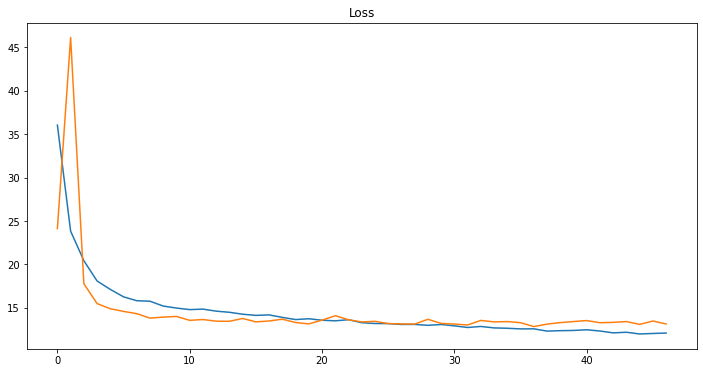

In [80]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show()

In [81]:
test_predict = model.predict([X_test, X_test.productionDate.values])
print(f"TEST mape: {(mape(y_test, test_predict[:,0]))*100:0.2f}%")

TEST mape: 12.58%


Точность текущей модели выше, чем у наивной модели. И выше,чем у предыдущих моделей,основанных на nn. Но ниже,чем у CatBoostRegressor. Сохраним результаты для усреднения.

## Predict

In [82]:
sub_predict = model.predict([X_sub, X_sub.productionDate.values])
sample_submission['price'] = sub_predict[:, 0]
sample_submission.to_csv('model_6.csv', index=False)

# округлим
sample_submission['price'] = (sample_submission['price'] // 1000) * 1000
sample_submission.to_csv('model_6_round.csv', index=False)

In [83]:
sample_submission

,sell_id,price
0,1099427284,473000.0
1,1096405886,2888000.0
2,1100195294,618000.0
3,1099827282,496000.0
4,1100076198,2717000.0
...,...,...
1666,1099414488,997000.0
1667,1099277058,2932000.0
1668,1098773964,1611000.0
1669,1098835932,1147000.0


# Total prediction

Усредним предсказания всех моделей (отдельно исходные/округленные)

In [73]:
DIR_PREDICTS = '../input/predicted-files/'

col_pred = []
col_pred_round = []

In [74]:
for dirname, _, filenames in os.walk(DIR_PREDICTS):
    for filename in filenames:
        if 'round' in filename:
            col_pred_round.append(DIR_PREDICTS + filename)
        else:
            col_pred.append(DIR_PREDICTS + filename)

In [75]:
col_pred

['../input/predicted-files/model_3.csv',
 '../input/predicted-files/model_4.csv',
 '../input/predicted-files/model_6.csv',
 '../input/predicted-files/catboost.csv',
 '../input/predicted-files/model_5.csv']

In [76]:
col_pred_round

['../input/predicted-files/catboost_round.csv',
 '../input/predicted-files/model_5_round.csv',
 '../input/predicted-files/model_3_round.csv',
 '../input/predicted-files/model_6_round.csv',
 '../input/predicted-files/model_4_round.csv']

In [77]:
def predict_total(col):
    data_pred = None
    for file in col:
        if data_pred is None:
            data_pred = pd.read_csv(file)
        else:    
            data_pred['price'] += pd.read_csv(file)['price']
            
    data_pred['price'] = data_pred['price']/len(col)
    
    return data_pred

In [78]:
sub = predict_total(col_pred)
sub.to_csv('submission.csv', index=False)

sub.head(2)

,sell_id,price
0,1099427284,4.867649e+05
1,1096405886,2.678021e+06


In [79]:
sub = predict_total(col_pred_round)
sub.to_csv('submission_round.csv', index=False)

sub.head(2)

,sell_id,price
0,1099427284,486200.0
1,1096405886,2677400.0


В итоге предсказания исходных данных показали себя лучше на leaderboarde ,чем округленных.